In [1]:
'''
Basic FBP reconstruction
'''

'\nBasic FBP reconstruction\n'

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pcct_md_diffusion.utils as utils

from leapctype import tomographicModels
from leap_preprocessing_algorithms import ringRemoval
from pcct_md_diffusion.fbp import additional_fbp_filter
from pcct_md_diffusion.locations import base_input_dir

In [3]:
geo_filename = os.path.join(base_input_dir, 'omnitom_pcd/geometry/omnitom_3x3_fan_fov_252.cfg')
sino_dir = os.path.join(base_input_dir, 'omnitom_pcd/recon/prj/44/')

In [6]:
sinogram, _, dv = utils.load_sinogram(sino_dir, channel=0, first_rotation=20, last_rotation=21)
sinogram, dv = utils.average_projection_slices(sinogram, dv, num_slices_to_average=2)
# sinogram = sinogram[:, :, [sinogram.shape[2]//2]]  # Take the center slice only

print(f'Sinogram shape: {sinogram.shape}, dv={dv}')

Loading channel 0...
Loading rotations (2): 0 1 done.
After removing inconsistent sinograms, 2 sinograms remain.
Sinogram shape: (1, 1440, 13, 896), dv=0.8479999899864197


Error: curved detector only defined for cone-beam geometries

======== CT Fan-Beam Geometry ========
number of angles: 1440
number of detector elements (rows, cols): 13 x 896
angular range: 360.000000 degrees
detector pixel size: 0.848000 mm x 0.572500 mm
center detector pixel: 6.000000, 455.690002
sod = 366.000000 mm
sdd = 596.000000 mm

======== CT Volume ========
number of voxels (x, y, z): 512 x 512 x 13
voxel size: 0.492188 mm x 0.492188 mm x 0.848000 mm
FOV: [-126.000000, 126.000000] x [-126.000000, 126.000000] x [-5.512000, 5.512000]

======== Processing Settings ========
GPU processing on device 0
GPU with least amount of memory: 35.161964 GB



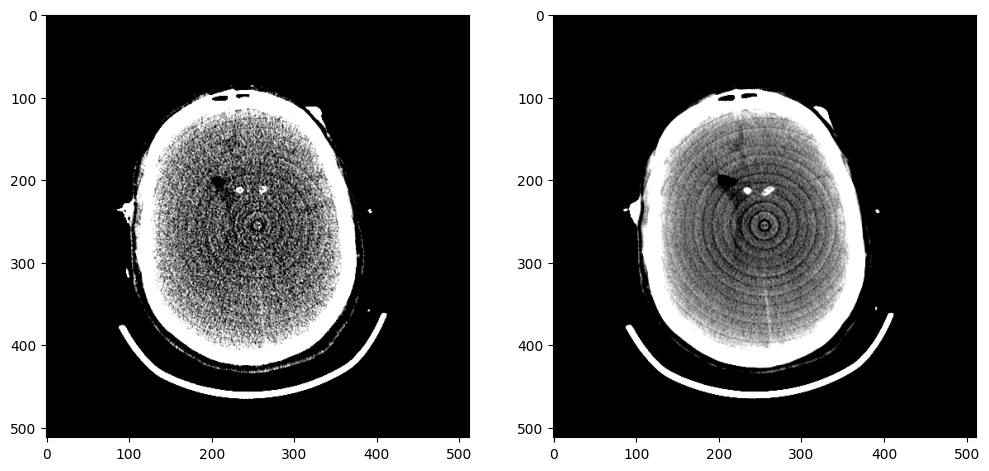

In [7]:
geo = utils.load_geometry(geo_filename)
# geo.du = du
geo.dv = dv
geo.dz = dv
geo.nu = sinogram.shape[-1]
geo.nv = sinogram.shape[2]
geo.nz = sinogram.shape[2]

leapct = utils.set_leapct_geometry(geo, geometry_type=utils.GeometryType.FAN)
leapct.set_curvedDetector()
leapct.print_parameters()

sino = np.copy(sinogram[0][..., ::-1], 'C')
sino = additional_fbp_filter(sino, 'hann')

recon = leapct.FBP(sino)

recon = recon / 0.02 * 1000 - 1000  # Convert to HU
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(recon[recon.shape[0] // 2, :, ::-1], cmap='gray', vmin=0, vmax=100)
plt.subplot(122)
plt.imshow(recon[:8, :, ::-1].mean(axis=0), cmap='gray', vmin=0, vmax=100)